In [1]:
import sys, os
os.path.dirname(sys.executable)
sys.path.append('/c4/home/sermare/fusioncharacterization_gliomas/')

from fcg.common_imports import *
import importlib
from fcg import data_utils
pd.set_option('display.max_columns', None)

In [2]:
metadata = pd.read_csv('/c4/home/sermare/tables_fusion_characterization/60_patients_metadata.csv')
gary_table = pd.read_csv('/c4/home/sermare/jupyter-notebooks/Gary_patient_samples.csv', header = 0)

In [3]:
samples_ran_arriba = glob.glob('/costellolab/data1/sermare/fusion_hg38/230502024/*/*trimming_report.txt')

def extract_file_path_version(fp):
    """
    Looks for patterns like 'V3', 'V9-2', etc. in file_path.
    We'll capture them as 'v3', 'v9-2', etc. to match the style used in SF#unique.
    """
    # Basic approach: look for 'V' + digits optionally followed by '-digits' etc.
    # e.g. "P533SF12827-V9_S290_" => we want "v9"
    # If you have multiple dashes like "V9-2", you'd handle that as well.
    # Adjust this regex if you have more complicated patterns:
    m = re.search(r'V(\d+(-\d+)?)', fp, flags=re.IGNORECASE)
    if m:
        # group(1) might be e.g. "9", or "9-2", etc.
        return m.group(1)  # e.g. "v9" or "v9-2"
    else:
        return None

# Store total reads processed per file
total_reads = {}

for file in samples_ran_arriba:
    with open(file, 'r') as f:
        for line in f:
            if "Total reads processed:" in line:
                # Extract the number using regex
                match = re.search(r"Total reads processed:\s+([\d,]+)", line)
                if match:
                    reads = int(match.group(1).replace(",", ""))  # Remove commas for conversion
                    total_reads[file] = reads

# Compute the sum of all reads processed
total_reads_sum = sum(total_reads.values())

# Print results
print(f"Total reads processed across all files: {total_reads_sum}")

df = pd.DataFrame(list(total_reads.items()), columns=["file", "processed_Arriba"])
df['file']  = df['file'].str.upper()
df['file'] = [x.split('/')[-1].replace('.fastq.gz_trimming_report.txt','').split('_L')[0] for x in df['file']]

samples_ran_arriba = glob.glob('/costellolab/data2/jocostello/rna_all/*/trimmed_fastqs/*trimming_report.txt')

# Store total reads processed per file
total_reads_jocostello = {}

for file in samples_ran_arriba:
    with open(file, 'r') as f:
        for line in f:
            if "Total reads processed:" in line:
                # Extract the number using regex
                match = re.search(r"Total reads processed:\s+([\d,]+)", line)
                if match:
                    reads = int(match.group(1).replace(",", ""))  # Remove commas for conversion
                    total_reads_jocostello[file] = reads    
            elif "Processed reads:" in line:
                # Extract the number using regex
                match = re.search(r"Processed reads:\s+([\d,]+)", line)
                if match:
                    reads = int(match.group(1).replace(",", ""))  # Remove commas for conversion
                    total_reads_jocostello[file] = reads

df_jocostello = pd.DataFrame(list(total_reads_jocostello.items()), columns=["file", "processed_reads"])

df_jocostello['Parent_Folder'] = [x.split('/')[-3] for x in df_jocostello['file']]

df_jocostello['trim_path']  = df_jocostello['file'].str.replace('_R1_001.fastq.gz_trimming_report.txt','_R1_001_val_1.fq.gz')
df_jocostello['trim_path']  = df_jocostello['trim_path'].str.replace('_R2_001.fastq.gz_trimming_report.txt', '_R2_001_val_2.fq.gz')

df_jocostello['file_name']  = df_jocostello['file'].str.replace('/trimmed_fastqs', '').str.replace('_trimming_report.txt', '')
df_jocostello['full_path']  = df_jocostello['file'].str.replace('/trimmed_fastqs', '').str.replace('_trimming_report.txt', '')

df_jocostello['file_name']  = [x.split('/')[-1] for x in df_jocostello['file_name']]

df_jocostello['file']  = df_jocostello['file'].str.upper()
df_jocostello['file'] = [x.split('/')[-1].replace('.fastq.gz_trimming_report.txt','').split('_L')[0].split('_R')[0] for x in df_jocostello['file']]

df_jocostello['Patient'] = df_jocostello['file'].apply(data_utils.extract_p_number)
df_jocostello['SF#'] = df_jocostello['file'].apply(data_utils.extract_sf_number)
df_jocostello = df_jocostello[df_jocostello['Patient'].notna()]

df_jocostello['V'] = df_jocostello['file_name'].apply(extract_file_path_version)
# df_jocostello = df_jocostello[df_jocostello['Patient'].notna()]
df_jocostello = df_jocostello.sort_values(by=['Parent_Folder','Patient','V'])

df_jocostello = pd.merge(left = df_jocostello, right = gary_table[['SF','Histology','Tumor']], left_on = 'SF#', right_on ='SF', how = 'left')[['Patient','Tumor','Histology','SF#','Parent_Folder','file','file_name','processed_reads','full_path', 'trim_path']]

merged_dataframe = pd.merge(left=df_jocostello, right=df, left_on='processed_reads', right_on='processed_Arriba', how='outer')
merged_dataframe['identical_processed'] = merged_dataframe['processed_Arriba'] == merged_dataframe['processed_reads']
merged_dataframe = merged_dataframe.drop_duplicates()

multisampled_rna = df_jocostello.groupby(['Patient','SF#'])['file'].size().reset_index().sort_values(by ='file').tail(76)

# df_jocostello.to_csv('COSTELLO_RNA_Metadata.csv', index = None)
missing_patients = ['P375', 'P260', 'P372', 'P340', 'P452', 'P413', 'P303', 'P302', 'P326', 'P502', 'P327', 'P532', 'P373'] 
# # Samples were not included in the analysis

Total reads processed across all files: 100409070950


/scratch/sermare/ipykernel_2971613/2280168362.py:67: FutureWarning: The default value of regex will change from True to False in a future version.
  df_jocostello['trim_path']  = df_jocostello['file'].str.replace('_R1_001.fastq.gz_trimming_report.txt','_R1_001_val_1.fq.gz')
/scratch/sermare/ipykernel_2971613/2280168362.py:68: FutureWarning: The default value of regex will change from True to False in a future version.
  df_jocostello['trim_path']  = df_jocostello['trim_path'].str.replace('_R2_001.fastq.gz_trimming_report.txt', '_R2_001_val_2.fq.gz')
/scratch/sermare/ipykernel_2971613/2280168362.py:70: FutureWarning: The default value of regex will change from True to False in a future version.
  df_jocostello['file_name']  = df_jocostello['file'].str.replace('/trimmed_fastqs', '').str.replace('_trimming_report.txt', '')
/scratch/sermare/ipykernel_2971613/2280168362.py:71: FutureWarning: The default value of regex will change from True to False in a future version.
  df_jocostello['full

In [4]:
sorted(df_jocostello[df_jocostello['Patient'].isin(missing_patients)]['Patient'].unique())

#326 373 372 502 DO NOT HAVE RNA-seq 

['P260', 'P302', 'P303', 'P327', 'P340', 'P375', 'P413', 'P452', 'P532']

In [5]:
df_jocostello['file'] = df_jocostello['file'].str.upper()

In [6]:
clonal_vs_depth = pd.merge(left= metadata, right = df_jocostello.drop_duplicates('file'), left_on='SF#', right_on = 'SF#', how= 'left')

In [7]:
clonal_vs_depth = clonal_vs_depth[clonal_vs_depth['file'].notna()]

In [8]:
# Filter rows where the value in 'file' is found in 'file_path_x'
clonal_vs_depth = clonal_vs_depth[
    clonal_vs_depth.apply(lambda row: row['file'] in row['file_path_x'], axis=1)
]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


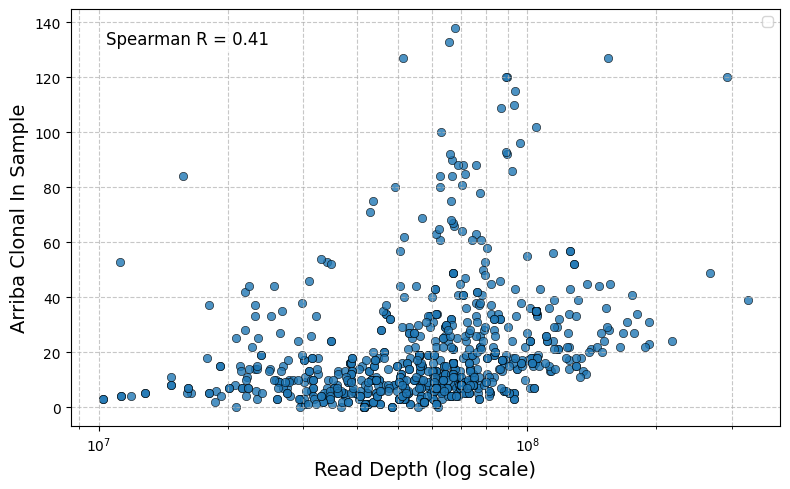

In [27]:
import scipy.stats as stats
spearman_corr, spearman_pval = stats.spearmanr(
    clonal_vs_depth['processed_reads'], clonal_vs_depth['Arriba_clonal_in_sample']
)

# Create the scatter plot
plt.figure(figsize=(8, 5))
ax = sns.scatterplot(
    data=clonal_vs_depth, 
    x='processed_reads', 
    y='Arriba_clonal_in_sample', 
    edgecolor='black', 
    alpha=0.8
)

# Set both axes to log scale
plt.xscale('log')
# plt.yscale('log')

# Determine range for the x = y line using the min and max values
min_val = min(clonal_vs_depth['processed_reads'].min(), clonal_vs_depth['Arriba_clonal_in_sample'].min())
max_val = max(clonal_vs_depth['processed_reads'].max(), clonal_vs_depth['Arriba_clonal_in_sample'].max())
x_line = np.linspace(min_val, max_val, 100)

# Plot the x = y line as a red, dotted line
# plt.plot(x_line, x_line, color='red', linestyle='dotted', linewidth=2, label='x = y')

# Set axis labels (no title)
plt.xlabel('Read Depth (log scale)', fontsize=14)
plt.ylabel('Arriba Clonal In Sample', fontsize=14)

# Annotate the Spearman correlation and p-value in the upper left corner
plt.text(0.05, 0.95, f"Spearman R = {spearman_corr:.2f}",
         transform=plt.gca().transAxes, fontsize=12, verticalalignment='top',
         bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

# Add grid and legend
plt.grid(True, which='both', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


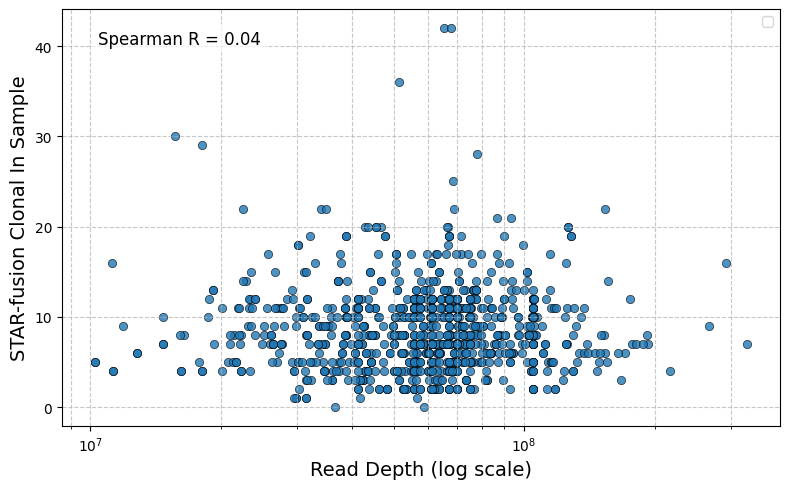

In [26]:
spearman_corr, spearman_pval = stats.spearmanr(
    clonal_vs_depth['processed_reads'], clonal_vs_depth['STAR_clonal_in_sample']
)

# Create the scatter plot
plt.figure(figsize=(8, 5))
ax = sns.scatterplot(
    data=clonal_vs_depth, 
    x='processed_reads', 
    y='STAR_clonal_in_sample', 
    edgecolor='black', 
    alpha=0.8
)

# Set both axes to log scale
plt.xscale('log')
# plt.yscale('log')

# Determine range for the x = y line using the min and max values
min_val = min(clonal_vs_depth['processed_reads'].min(), clonal_vs_depth['STAR_clonal_in_sample'].min())
max_val = max(clonal_vs_depth['processed_reads'].max(), clonal_vs_depth['STAR_clonal_in_sample'].max())
x_line = np.linspace(min_val, max_val, 100)

# Plot the x = y line as a red, dotted line
# plt.plot(x_line, x_line, color='red', linestyle='dotted', linewidth=2, label='x = y')

# Set axis labels (no title)
plt.xlabel('Read Depth (log scale)', fontsize=14)
plt.ylabel('STAR-fusion Clonal In Sample', fontsize=14)

# Annotate the Spearman correlation and p-value in the upper left corner
plt.text(0.05, 0.95, f"Spearman R = {spearman_corr:.2f}",
         transform=plt.gca().transAxes, fontsize=12, verticalalignment='top',
         bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

# Add grid and legend
plt.grid(True, which='both', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


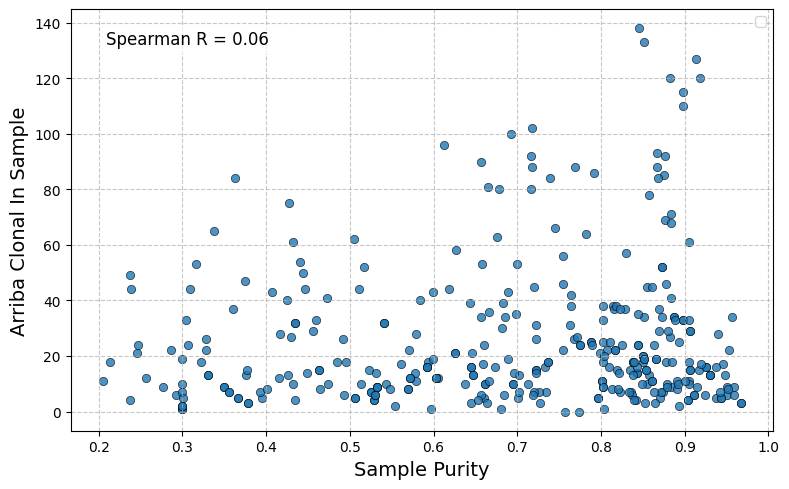

In [25]:
spearman_corr, spearman_pval = stats.spearmanr(
    clonal_vs_depth[(clonal_vs_depth['Histology_x'] != 'Astro' ) & (clonal_vs_depth['FACET_purity'].notna())]['FACET_purity'], clonal_vs_depth[(clonal_vs_depth['Histology_x'] != 'Astro' ) & (clonal_vs_depth['FACET_purity'].notna())]['Arriba_clonal_in_sample']
)

# Create the scatter plot
plt.figure(figsize=(8, 5))
ax = sns.scatterplot(
    data=clonal_vs_depth[(clonal_vs_depth['Histology_x'] != 'Astro' ) & (clonal_vs_depth['FACET_purity'].notna())], 
    x='FACET_purity', 
    y='Arriba_clonal_in_sample', 
    edgecolor='black', 
    alpha=0.8
)

# Determine range for the x = y line using the min and max values
min_val = min(clonal_vs_depth[(clonal_vs_depth['Histology_x'] != 'Astro' ) & (clonal_vs_depth['FACET_purity'].notna())]['FACET_purity'].min(), clonal_vs_depth[(clonal_vs_depth['Histology_x'] != 'Astro' ) & (clonal_vs_depth['FACET_purity'].notna())]['Arriba_clonal_in_sample'].min())
max_val = max(clonal_vs_depth[(clonal_vs_depth['Histology_x'] != 'Astro' ) & (clonal_vs_depth['FACET_purity'].notna())]['FACET_purity'].max(), clonal_vs_depth[(clonal_vs_depth['Histology_x'] != 'Astro' ) & (clonal_vs_depth['FACET_purity'].notna())]['Arriba_clonal_in_sample'].max())
x_line = np.linspace(min_val, max_val, 100)

# Plot the x = y line as a red, dotted line
# plt.plot(x_line, x_line, color='red', linestyle='dotted', linewidth=2, label='x = y')

# Set axis labels (no title)
plt.xlabel('Sample Purity', fontsize=14)
plt.ylabel('Arriba Clonal In Sample', fontsize=14)

# Annotate the Spearman correlation and p-value in the upper left corner
plt.text(0.05, 0.95, f"Spearman R = {spearman_corr:.2f}",
         transform=plt.gca().transAxes, fontsize=12, verticalalignment='top',
         bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

# Add grid and legend
plt.grid(True, which='both', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


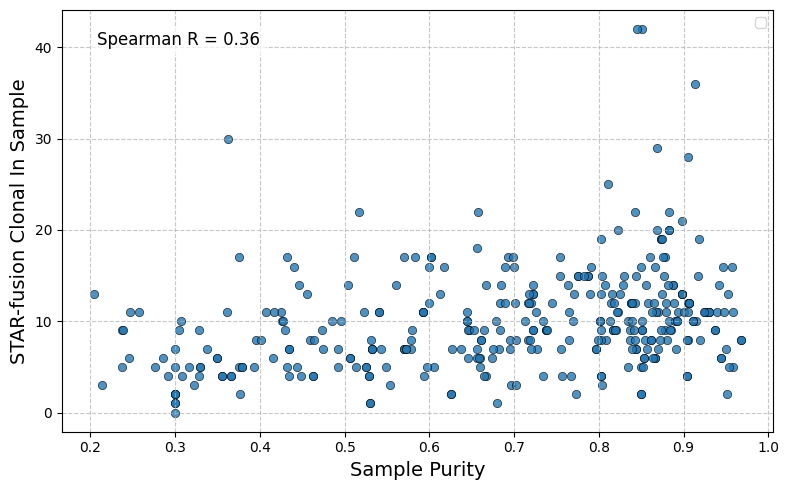

In [28]:
spearman_corr, spearman_pval = stats.spearmanr(
    clonal_vs_depth[(clonal_vs_depth['Histology_x'] != 'Astro' ) & (clonal_vs_depth['FACET_purity'].notna())]['FACET_purity'], clonal_vs_depth[(clonal_vs_depth['Histology_x'] != 'Astro' ) & (clonal_vs_depth['FACET_purity'].notna())]['STAR_clonal_in_sample']
)

# Create the scatter plot
plt.figure(figsize=(8, 5))
ax = sns.scatterplot(
    data=clonal_vs_depth[(clonal_vs_depth['Histology_x'] != 'Astro' ) & (clonal_vs_depth['FACET_purity'].notna())], 
    x='FACET_purity', 
    y='STAR_clonal_in_sample', 
    edgecolor='black', 
    alpha=0.8
)

# Set both axes to log scale
# plt.xscale('log')
# plt.yscale('log')

# Determine range for the x = y line using the min and max values
min_val = min(clonal_vs_depth[(clonal_vs_depth['Histology_x'] != 'Astro' ) & (clonal_vs_depth['FACET_purity'].notna())]['FACET_purity'].min(), clonal_vs_depth[(clonal_vs_depth['Histology_x'] != 'Astro' ) & (clonal_vs_depth['FACET_purity'].notna())]['STAR_clonal_in_sample'].min())
max_val = max(clonal_vs_depth[(clonal_vs_depth['Histology_x'] != 'Astro' ) & (clonal_vs_depth['FACET_purity'].notna())]['FACET_purity'].max(), clonal_vs_depth[(clonal_vs_depth['Histology_x'] != 'Astro' ) & (clonal_vs_depth['FACET_purity'].notna())]['STAR_clonal_in_sample'].max())
x_line = np.linspace(min_val, max_val, 100)

# Plot the x = y line as a red, dotted line
# plt.plot(x_line, x_line, color='red', linestyle='dotted', linewidth=2, label='x = y')

# Set axis labels (no title)
plt.xlabel('Sample Purity', fontsize=14)
plt.ylabel('STAR-fusion Clonal In Sample', fontsize=14)

# Annotate the Spearman correlation and p-value in the upper left corner
plt.text(0.05, 0.95, f"Spearman R = {spearman_corr:.2f}",
         transform=plt.gca().transAxes, fontsize=12, verticalalignment='top',
         bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

# Add grid and legend
plt.grid(True, which='both', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()


In [13]:
def extract_input_fq_files(log_file):
    """
    Open a STAR Log.out file and extract the two FASTQ input filenames 
    from the line that contains '--readFilesIn'.
    """
    with open(log_file, 'r') as f:
        for line in f:
            if '--readFilesIn' in line:
                # Get the part after '--readFilesIn'
                parts = line.split('--readFilesIn', 1)
                if len(parts) > 1:
                    read_files_str = parts[1].strip()
                    tokens = read_files_str.split()
                    # Expect at least two tokens (R1 and R2)
                    if len(tokens) >= 2:
                        return tokens[0], tokens[1]
    return None, None

# List to accumulate rows for the new DataFrame
rows = []

for idx, row in metadata.iterrows():
    folder = row.get('complete_path')
    
    # Skip rows where 'complete_path' is not a valid string
    if not isinstance(folder, str):
        print(f"Skipping row {idx}: invalid complete_path {folder}")
        continue

    # Remove the last part (the filename) to get the folder
    folder = os.path.dirname(folder)
    
    # Find all Log.out files in the folder
    log_files = glob.glob(os.path.join(folder, '*Log.out'))
    if not log_files:
        print(f"No Log.out files found in folder: {folder}")
        continue

    # Assume the first found log file is the one to use
    r1_input, r2_input = extract_input_fq_files(log_files[0])
    
    # Build a new row with selected metadata and the extracted FASTQ file paths
    new_row = {
        'SF#': row['SF#'],
        'arriba_filename': row['file_path_x'],
        'patient': row['patient'],
        'Histology': row['Histology'],
        'Tumor': row['Tumor'],
        'R1': r1_input,
        'R2': r2_input
    }
    rows.append(new_row)

# Create the new DataFrame
new_df = pd.DataFrame(rows)


Skipping row 575: invalid complete_path nan


In [14]:
metadata_copy = metadata.drop_duplicates('file_path_x')

In [15]:
def extract_version(file_path):
    match = re.search(r'V(\d+)', file_path)
    return int(match.group(1)) if match else None

# Add a new column for version numbers
metadata['version'] = metadata['file_path_x'].astype(str).apply(extract_version)

# Find the maximum version per SF#
max_versions = metadata.groupby('SF#')['version'].max().reset_index()
max_versions['version'] = max_versions['version'].fillna(0).astype(int)

# Create lookup dictionaries for file_path_x and complete_path
lookup_dict = metadata.set_index(['SF#', 'version'])['file_path_x'].to_dict()
complete_path_lookup = metadata.set_index(['SF#', 'version'])['complete_path'].to_dict()
sf_lookup_dict = metadata.set_index(['SF#'])['patient'].to_dict()

# Generate the complete version table per patient
expanded_data = [
    {
        "patient": sf_lookup_dict.get(row['SF#'], None),
        "complete_path": complete_path_lookup.get((row['SF#'], v), None),
        "SF#": row['SF#'],
        "version": int(v),
        "file_path_x": lookup_dict.get((row['SF#'], v), None)
    }
    for _, row in max_versions.iterrows()
    for v in range(1, int(row['version']) + 1)
]

# Create the final expanded DataFrame
expanded_metadata = pd.DataFrame(expanded_data)
expanded_metadata = expanded_metadata.sort_values(by=['SF#', 'version'])


In [16]:
directory_path = "/costellolab/data2/jocostello/rna_all"

# List of patients to exclude
excluded_patients = [
    'P300', 'P471', 'P457', 'P481', 'P458',
    'P499', 'P500', 'P507', 'P516', 'P498',
    'P505', 'P521', 'P524', 'P547', 'P528'
]

# Find rows where 'file_path_x' is NaN (missing)
missing_file_paths = expanded_metadata[expanded_metadata['file_path_x'].isna()]

# Remove rows for the excluded patients
missing_file_paths = missing_file_paths[~missing_file_paths['patient'].isin(excluded_patients)]

# Dictionary to store found FASTQ file paths
found_fastq_files = {}

# Iterate through each missing entry to find corresponding FASTQ files
for index, row in missing_file_paths.iterrows():
    patient = row['patient']
    sf_number = row['SF#']
    vial = row['version']
    
    # If complete_path is not NaN, remove the file name to get the folder path.
    # (If complete_path is NaN, we skip this row.)
    if pd.notna(row['complete_path']):
        folder = os.path.dirname(row['complete_path'])
    else:
        continue

    # Construct the search pattern for FASTQ files related to the sf_number and vial
    search_pattern = f"{directory_path}/*/trim*/*{sf_number}*{vial}_S*fq.gz"
    
    # Use glob to find matching files
    matching_files = glob.glob(search_pattern)
    
    # Create a name identifier from patient, SF#, and vial
    name = f"{patient}{sf_number}V{vial}"
    
    # Store the results (if no files were found, None is stored)
    found_fastq_files[name] = matching_files if matching_files else None

# # Optionally, if you want to remove these rows from the original expanded_metadata DataFrame,
# # you can do so by filtering it:
# expanded_metadata = expanded_metadata[~expanded_metadata['patient'].isin(excluded_patients) | expanded_metadata['file_path_x'].notna()]

In [17]:
expanded_metadata[~(expanded_metadata['file_path_x'].notna())]

,patient,complete_path,SF#,version,file_path_x
1,P300,None,SF10711,2,None
2,P300,None,SF10711,3,None
8,P300,None,SF10711,9,None
46,P471,None,SF11834,7,None
72,P458,None,SF11913,3,None
82,P457,None,SF11915,1,None
85,P457,None,SF11915,4,None
86,P457,None,SF11915,5,None
88,P457,None,SF11915,7,None
90,P457,None,SF11915,9,None


In [18]:
# P528 SF12790 v6 /costellolab/data2/jocostello/rna_all/CHJC26/P528SF12790-v6-1_S29_R1_001.fastq.gz
# P457 SF11915 v9 is missing /costellolab/data2/jocostello/rna_all/CHJC09/P457SF11915v9_S25_R1_001.fastq.gz

In [19]:
sample_to_files = {}

# Filter your dataframe for specific patients first
selected_df = df_jocostello[
    df_jocostello['Patient'].isin(['P375', 'P260', 'P372', 'P340', 'P452', 'P413', 'P303', 'P302', 'P326', 'P502', 'P327', 'P532', 'P373'] ) #['P413', 'P302', 'P452', 'P375', 'P340', 'P327', 'P303', 'P532'])
]

unique_paths = selected_df['trim_path'].unique()

for idx in range(0, len(unique_paths)):
    # Ensure there's a pair available
    if idx + 1 >= len(unique_paths):
        break

    file_1 = unique_paths[idx]
    file_2 = unique_paths[idx + 1]

    sample_name = file_1.split('/')[-1].split('_S')[0]

    sample_to_files[sample_name] = [file_1, file_2]

In [20]:
script_folder = "/costellolab/data1/sermare/fusion_hg38/230502024/SLURM_JOBS"
folder = "/costellolab/data1/sermare/fusion_hg38/230502024"

# Process each sample from the dictionary
for sample_name, fastq_files in sample_to_files.items():
    print(f"Processing: {sample_name}")

    # Get the R1 and R2 file paths
    r1_file = fastq_files[0] if '_R1_' in fastq_files[0] else fastq_files[1]
    r2_file = fastq_files[1] if '_R2_' in fastq_files[1] else fastq_files[0]

    # Extract filenames from full paths
    trimmed_file_1 = os.path.basename(r1_file)
    trimmed_file_2 = os.path.basename(r2_file)

    # Use the sample name directly from the dictionary key
    sample_output = sample_name

    # Create the path for the SLURM script file
    script_file_path = os.path.join(script_folder, f"{sample_output}.sh")

    with open(script_file_path, "w") as file:
        # Write SLURM header
        file.write("#!/bin/bash\n")
        file.write(f"#SBATCH --job-name={sample_output}\n")
        file.write("#SBATCH --nodes=1\n")
        file.write("#SBATCH --partition=costellolab\n")
        file.write("#SBATCH --ntasks=1\n")
        file.write("#SBATCH --mem=200G\n")
        file.write("#SBATCH --time=99:00:00\n")
        file.write(f"#SBATCH --output={script_folder}/ERROR/%x-%j.out\n")
        file.write(f"#SBATCH --error={script_folder}/error_%j.err\n")
        file.write("#SBATCH --mail-type=END,FAIL\n")
        file.write("#SBATCH --mail-user=sergiomar10@berkeley.edu\n\n")

        # Change to the fusions directory and load required modules
        file.write(f"cd {folder}\n")
        file.write("module load CBI\n")
        file.write("module load WitteLab\n")
        file.write("module load python3\n\n")
        file.write("source /costellolab/data3/sermare/miniconda3/etc/profile.d/conda.sh\n")
        file.write("conda activate Arriba\n\n")

        # Create and move into the sample-specific output directory
        file.write(f"mkdir -p {folder}/{sample_output}\n")
        file.write(f"cd {folder}/{sample_output}\n\n")

        # Build the STAR and Arriba command pipeline
        star_command = (
            "STAR "
            "--runThreadN 8 "
            "--genomeDir /costellolab/data3/sermare/arriba_hg38/STAR_index_hg38_GENCODE38 --genomeLoad NoSharedMemory "
            f"--readFilesIn {r1_file} {r2_file} --readFilesCommand zcat "
            "--outStd BAM_Unsorted --outSAMtype BAM Unsorted --outSAMunmapped Within --outBAMcompression 0 "
            "--outFilterMultimapNmax 50 --peOverlapNbasesMin 10 --alignSplicedMateMapLminOverLmate 0.5 "
            "--alignSJstitchMismatchNmax 5 -1 5 5 "
            "--chimSegmentMin 10 --chimOutType WithinBAM HardClip --chimJunctionOverhangMin 10 --chimScoreDropMax 30 "
            "--chimScoreJunctionNonGTAG 0 --chimScoreSeparation 1 --chimSegmentReadGapMax 3 --chimMultimapNmax 50 | "
            "arriba "
            "-x /dev/stdin "
            f"-o {sample_output}_fusions.tsv -O {sample_output}_fusions.discarded.tsv "
            "-a /costellolab/data3/sermare/arriba_hg38/hg38.fa -g /costellolab/data3/sermare/arriba_hg38/GENCODE38.gtf "
            "-b /costellolab/data3/sermare/arriba_v2.3.0/database/blacklist_hg38_GRCh38_v2.3.0.tsv.gz "
            "-k /costellolab/data3/sermare/arriba_v2.3.0/database/known_fusions_hg38_GRCh38_v2.3.0.tsv.gz "
            "-t /costellolab/data3/sermare/arriba_v2.3.0/database/known_fusions_hg38_GRCh38_v2.3.0.tsv.gz "
            "-p /costellolab/data3/sermare/arriba_v2.3.0/database/protein_domains_hg38_GRCh38_v2.3.0.gff3"
        )
        file.write(star_command + "\n")

Processing: p303SF10809v1
Processing: p303SF10809v10
Processing: p303
Processing: p303SF10809v3
Processing: p303SF10809v4
Processing: p303SF10809v6
Processing: p303SF10809v9
Processing: P375SF11136v1
Processing: P375SF11136v10
Processing: P375SF11136v2
Processing: P375SF11136v3
Processing: P375SF11136v4
Processing: P375SF11136v5
Processing: P375SF11136v6
Processing: P375SF11136v7
Processing: P375SF11136v8
Processing: P375SF11136v9
Processing: p260SF11294v1
Processing: p260SF11294v10
Processing: p260SF11294v11
Processing: p260SF11294v12
Processing: p260SF11294v13
Processing: p260SF11294v14
Processing: p260SF11294v15
Processing: p260SF11294v17
Processing: p260SF11294v18
Processing: p260SF11294v19
Processing: p260SF11294v2
Processing: p260SF11294v20
Processing: p260SF11294v3
Processing: p260SF11294v4
Processing: p260SF11294v5
Processing: p260SF11294v6
Processing: p260SF11294v7
Processing: p260SF11294v8
Processing: p260SF11294v9
Processing: p302SF10788v1
Processing: p302SF10788v10
Processi

In [21]:
script_folder = "/costellolab/data1/sermare/fusion_hg38/230502024/SLURM_JOBS"
folder = "/costellolab/data1/sermare/fusion_hg38/230502024"

# Process each sample from the dictionary
for sample_name, fastq_files in sample_to_files.items():
    print(f"Processing: {sample_name}")

    # Determine the left (R1) and right (R2) FASTQ files
    left_fq = fastq_files[0] if '_R1_' in fastq_files[0] else fastq_files[1]
    right_fq = fastq_files[1] if '_R2_' in fastq_files[1] else fastq_files[0]

    # Use the sample name directly as the output directory name
    sample_output = sample_name

    # Create the full path for the SLURM script file
    script_file_path = os.path.join(script_folder, f"STAR_{sample_output}.sh")

    with open(script_file_path, "w") as file:
        # Write SLURM header with STAR-Fusion settings
        file.write("#!/bin/bash\n")
        file.write(f"#SBATCH --job-name=STAR-Fusion_{sample_output}\n")
        file.write("#SBATCH --nodes=1\n")
        file.write("#SBATCH --partition=costellolab\n")
        file.write("#SBATCH --ntasks=1\n")
        file.write("#SBATCH --mem=201G\n")
        file.write("#SBATCH --time=99:00:00\n")
        file.write("#SBATCH --output=%x-%j.out\n")
        file.write("#SBATCH --mail-type=END,FAIL\n")
        file.write("#SBATCH --mail-user=sergiomar10@berkeley.edu\n\n")
        
        # Change to the FusionInspector directory
        file.write("cd /costellolab/data3/sermare/FusionInspector\n\n")
        
        # Load required modules
        file.write("module load CBI\n")
        file.write("module load samtools\n\n")
        
        # Activate the conda environment for STAR-Fusion
        file.write("source /costellolab/data3/sermare/miniconda3/etc/profile.d/conda.sh\n")
        file.write("conda activate star_fusion_2\n\n")
        
        file.write("\n")
        # Load samtools module (again, if needed)
        load_module_command = "module load samtools"
        file.write(load_module_command + "\n")
        
        # Change directory to the sample-specific output folder
        cd_command = f"cd {sample_output}"
        file.write(cd_command + "\n")
        
        # Write the STAR-Fusion command with updated paths and file variables
        bash_command = (
            "/costellolab/data3/sermare/STAR-Fusion/STAR-Fusion-v1.10.0/STAR-Fusion  \\\n"
            "    --genome_lib_dir /costellolab/data1/sermare/tools/CTAT/download/GRCh38_gencode_v37_CTAT_lib_Mar012021.plug-n-play/ctat_genome_lib_build_dir/ \\\n"
            f"    --left_fq {left_fq} --right_fq {right_fq} \\\n"
            f"    --output_dir {folder}/{sample_output}"
        )
        file.write("\n")
        file.write(bash_command + "\n")


Processing: p303SF10809v1
Processing: p303SF10809v10
Processing: p303
Processing: p303SF10809v3
Processing: p303SF10809v4
Processing: p303SF10809v6
Processing: p303SF10809v9
Processing: P375SF11136v1
Processing: P375SF11136v10
Processing: P375SF11136v2
Processing: P375SF11136v3
Processing: P375SF11136v4
Processing: P375SF11136v5
Processing: P375SF11136v6
Processing: P375SF11136v7
Processing: P375SF11136v8
Processing: P375SF11136v9
Processing: p260SF11294v1
Processing: p260SF11294v10
Processing: p260SF11294v11
Processing: p260SF11294v12
Processing: p260SF11294v13
Processing: p260SF11294v14
Processing: p260SF11294v15
Processing: p260SF11294v17
Processing: p260SF11294v18
Processing: p260SF11294v19
Processing: p260SF11294v2
Processing: p260SF11294v20
Processing: p260SF11294v3
Processing: p260SF11294v4
Processing: p260SF11294v5
Processing: p260SF11294v6
Processing: p260SF11294v7
Processing: p260SF11294v8
Processing: p260SF11294v9
Processing: p302SF10788v1
Processing: p302SF10788v10
Processi

In [22]:
# P528 SF12790 v6 /costellolab/data2/jocostello/rna_all/CHJC26/P528SF12790-v6-1_S29_R1_001.fastq.gz
# P457 SF11915 v9 is missing /costellolab/data2/jocostello/rna_all/CHJC09/P457SF11915v9_S25_R1_001.fastq.gz
found_fastq_files

{}

In [23]:
found_fastq_files_other = {'P528SF12790-v6-1': ['/costellolab/data2/jocostello/rna_all/CHJC26/P528SF12790-v6-1_S29_R1_001.fastq.gz',
 '/costellolab/data2/jocostello/rna_all/CHJC26/P528SF12790-v6-1_S29_R2_001.fastq.gz'], 
                    'P528SF12790-v6-2' : ['/costellolab/data2/jocostello/rna_all/CHJC26/P528SF12790-v6-2_S30_R1_001.fastq.gz',
 '/costellolab/data2/jocostello/rna_all/CHJC26/P528SF12790-v6-2_S30_R2_001.fastq.gz'], 
                    'P457SF11915v9':['/costellolab/data2/jocostello/rna_all/CHJC09/P457SF11915v9_S25_R1_001.fastq.gz',
 '/costellolab/data2/jocostello/rna_all/CHJC09/P457SF11915v9_S25_R2_001.fastq.gz']}

In [24]:
script_folder = "/costellolab/data1/sermare/fusion_hg38/230502024/SLURM_JOBS"
folder = "/costellolab/data1/sermare/fusion_hg38/230502024"

# Process each sample from the dictionary
for sample_name, fastq_files in found_fastq_files_other.items():
    print(f"Processing: {sample_name}")

    # Get the R1 and R2 file paths
    r1_file = fastq_files[0] if '_R1_' in fastq_files[0] else fastq_files[1]
    r2_file = fastq_files[1] if '_R2_' in fastq_files[1] else fastq_files[0]

    # Extract filenames from full paths
    trimmed_file_1 = os.path.basename(r1_file)
    trimmed_file_2 = os.path.basename(r2_file)

    # Use the sample name directly from the dictionary key
    sample_output = sample_name

    # Create the path for the SLURM script file
    script_file_path = os.path.join(script_folder, f"{sample_output}.sh")

    with open(script_file_path, "w") as file:
        # Write SLURM header
        file.write("#!/bin/bash\n")
        file.write(f"#SBATCH --job-name={sample_output}\n")
        file.write("#SBATCH --nodes=1\n")
        file.write("#SBATCH --partition=costellolab\n")
        file.write("#SBATCH --ntasks=1\n")
        file.write("#SBATCH --mem=50G\n")
        file.write("#SBATCH --time=99:00:00\n")
        file.write(f"#SBATCH --output={script_folder}/ERROR/%x-%j.out\n")
        file.write(f"#SBATCH --error={script_folder}/error_%j.err\n")
        file.write("#SBATCH --mail-type=END,FAIL\n")
        file.write("#SBATCH --mail-user=sergiomar10@berkeley.edu\n\n")

        # Change to the fusions directory and load required modules
        file.write(f"cd {folder}\n")
        file.write("module load CBI\n")
        file.write("module load WitteLab\n")
        file.write("module load python3\n\n")
        file.write("source /costellolab/data3/sermare/miniconda3/etc/profile.d/conda.sh\n")
        file.write("conda activate Arriba\n\n")

        # Create and move into the sample-specific output directory
        file.write(f"mkdir -p {folder}/{sample_output}\n")
        file.write(f"cd {folder}/{sample_output}\n\n")

        # Build the STAR and Arriba command pipeline
        star_command = (
            "STAR "
            "--runThreadN 8 "
            "--genomeDir /costellolab/data3/sermare/arriba_hg38/STAR_index_hg38_GENCODE38 --genomeLoad NoSharedMemory "
            f"--readFilesIn {r1_file} {r2_file} --readFilesCommand zcat "
            "--outStd BAM_Unsorted --outSAMtype BAM Unsorted --outSAMunmapped Within --outBAMcompression 0 "
            "--outFilterMultimapNmax 50 --peOverlapNbasesMin 10 --alignSplicedMateMapLminOverLmate 0.5 "
            "--alignSJstitchMismatchNmax 5 -1 5 5 "
            "--chimSegmentMin 10 --chimOutType WithinBAM HardClip --chimJunctionOverhangMin 10 --chimScoreDropMax 30 "
            "--chimScoreJunctionNonGTAG 0 --chimScoreSeparation 1 --chimSegmentReadGapMax 3 --chimMultimapNmax 50 | "
            "arriba "
            "-x /dev/stdin "
            f"-o {sample_output}_fusions.tsv -O {sample_output}_fusions.discarded.tsv "
            "-a /costellolab/data3/sermare/arriba_hg38/hg38.fa -g /costellolab/data3/sermare/arriba_hg38/GENCODE38.gtf "
            "-b /costellolab/data3/sermare/arriba_v2.3.0/database/blacklist_hg38_GRCh38_v2.3.0.tsv.gz "
            "-k /costellolab/data3/sermare/arriba_v2.3.0/database/known_fusions_hg38_GRCh38_v2.3.0.tsv.gz "
            "-t /costellolab/data3/sermare/arriba_v2.3.0/database/known_fusions_hg38_GRCh38_v2.3.0.tsv.gz "
            "-p /costellolab/data3/sermare/arriba_v2.3.0/database/protein_domains_hg38_GRCh38_v2.3.0.gff3"
        )
        file.write(star_command + "\n")

Processing: P528SF12790-v6-1
Processing: P528SF12790-v6-2
Processing: P457SF11915v9
